### Import statements

In [40]:
import sys
from sklearn import metrics
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20.0, 10.0),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':30,
         'ytick.labelsize':'x-large'}
matplotlib.rcParams.update(params)

import sys
from sklearn import metrics
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.feature_extraction.text import TfidfVectorizer
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


tdfn = pd.read_csv("known_identity_df.csv")

mention_threshold = .1



vectorizer = TfidfVectorizer(stop_words='english')
text_mat = vectorizer.fit_transform(tdfn.comment_text)
lr = LogisticRegression()
clf = lr.fit(text_mat,tdfn.predicted_toxicity)


/Users/benwolfson/anaconda3/envs/data_resp/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Read inputs

In [41]:
#Load files
pdf = pd.read_csv("submission.csv")
tdf = pd.read_csv("test_private_expanded.csv")
#Get target and predicted
y_true = tdf.toxicity
y_pred = pdf.prediction
y_bin_true = (y_true >= .5) 
y_bin_pred = (y_pred >= .5) 

### Build logistic regression on data and our model prediction

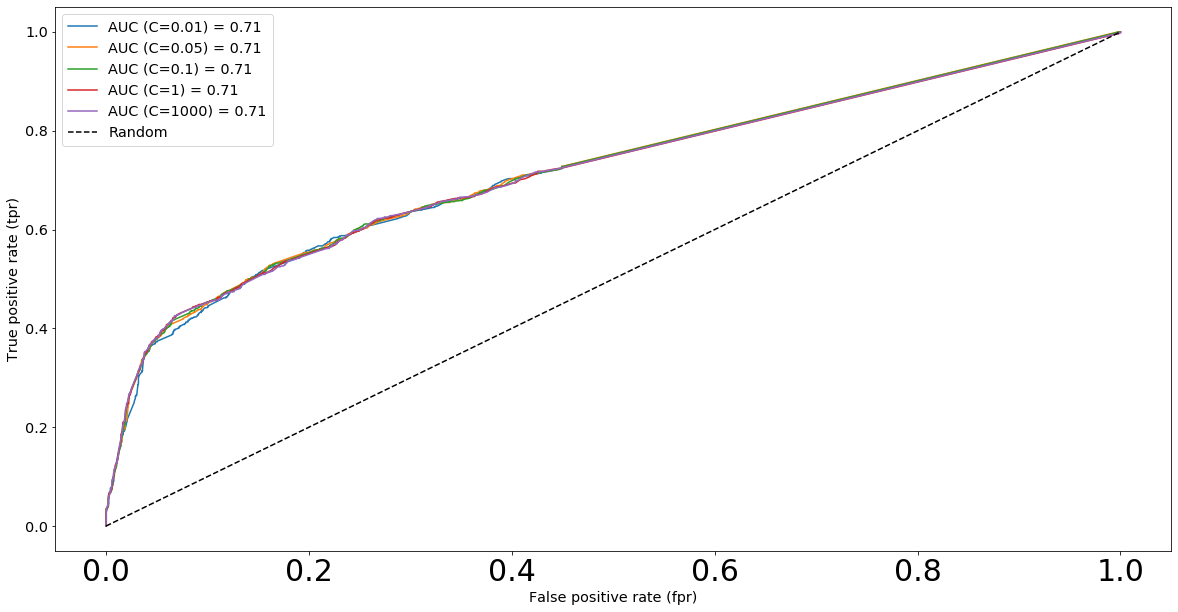

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

race_known = tdf.identity_annotator_count > 0
tdfn = tdf[race_known]
y_predn = y_bin_pred[race_known]
#Split train and test
X_train, X_test, Y_train, Y_test = train_test_split(tdfn.iloc[:,21:], y_predn, test_size=.2)

# Fit a logistic regression model
for c in [0.01, 0.05, .1, 1,1000]:
    model = LogisticRegression(C=c, solver='liblinear')
    model.fit(X_train, Y_train)

    # Get the probability of Y_test records being = 1
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability_1)
    
    # Get the area under the curve (AUC)
    auc = np.mean(cross_val_score(model, X_train, Y_train, scoring="roc_auc", cv=5))

    # Plot the ROC curve
    plt.plot(fpr, tpr, label="AUC (C=" + str(c) + ") = " + str(round(auc, 2)))
    
plt.xlabel("False positive rate (fpr)")
plt.ylabel("True positive rate (tpr)")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.legend(loc='best')

### Notice that the weights are disproportionally distributed

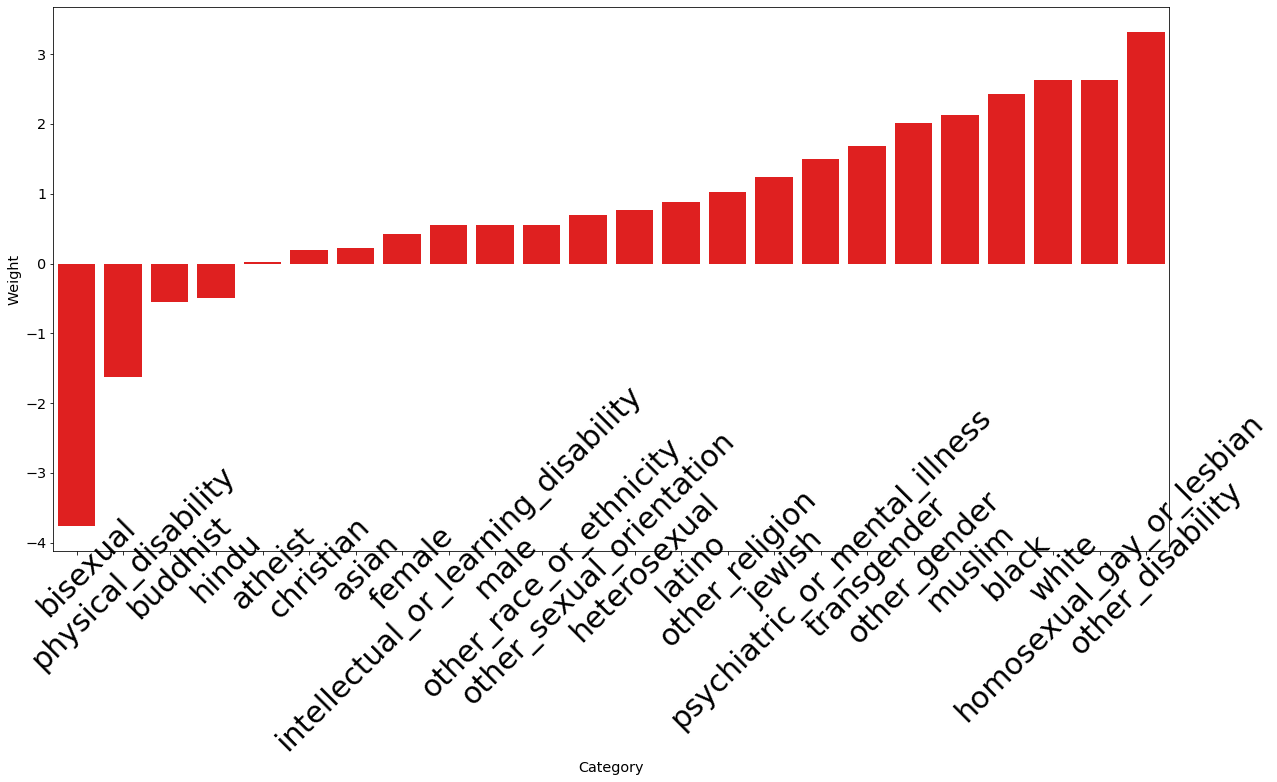

In [43]:
df = pd.DataFrame(zip(model.coef_[0], tdfn.iloc[:,21:].columns.values),columns = ["Weight","Category"])
#df.index = df["Category"]
df = df.sort_values(by="Weight")
#df = df.drop(["Category"],axis = 1)
ax = sns.barplot(x="Category",y="Weight",data=df,color="red",orient="v")
_ = ax.set_xticklabels(df.Category, rotation=45, rotation_mode="anchor")

In [44]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)



######
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
    
#####
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['toxicity'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df
#####
identity_columns = [
    'male', 'female', 'transgender',
       'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual',
       'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu',
       'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian',
       'latino', 'other_race_or_ethnicity', 'physical_disability',
       'intellectual_or_learning_disability', 'psychiatric_or_mental_illness',
       'other_disability']

tdf["pred"] = pdf.prediction
bdf = convert_dataframe_to_bool(tdf)
bias_metrics_df = compute_bias_metrics_for_model(bdf, identity_columns, "pred", "toxicity")


### Look at the official competition bias metrics, both for toxicity and severe toxicity   

#### Regular toxicity

In [45]:
# Sort over regular toxicity

def select_sort(df,col,**kwargs):
    ndf = df.sort_values(by=col,**kwargs)
    return ndf[["subgroup","subgroup_size",col]]

bmetrics = {
    #"subgroup_size":"Size of the subgroup",
    "subgroup_auc":"A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity.",
    "bpsn_auc":"A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not, likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.",
    "bnsp_auc":"A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not, likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity."
}

for metric in bmetrics:
    print("####")
    print(metric)
    print(bmetrics[metric])
    select_sort(bias_metrics_df,metric,ascending = True).head(10)
    print("####")

bias_metrics_df

####
subgroup_auc
A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity.
####
####
bpsn_auc
A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not, likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.
####
####
bnsp_auc
A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not, likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity.
####


,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
4,heterosexual,66,0.859216,0.897242,0.969293
5,homosexual_gay_or_lesbian,538,0.859595,0.910076,0.965246
15,black,761,0.870321,0.903006,0.970789
16,white,1178,0.876182,0.903431,0.972399
10,muslim,1054,0.879888,0.926397,0.964278
12,buddhist,27,0.880435,0.969448,0.921621
2,transgender,129,0.902166,0.924760,0.970291
17,asian,217,0.913022,0.961650,0.951700
9,jewish,411,0.914980,0.942269,0.965954
13,atheist,149,0.916547,0.971227,0.939762


#### Severe

In [46]:
sbdf = bdf.copy()
sbdf["severe_toxicity"] = sbdf["severe_toxicity"] > 0
bias_metrics_df = compute_bias_metrics_for_model(sbdf, identity_columns, "pred", "severe_toxicity")

for metric in bmetrics:
    print("####")
    print(metric)
    print(bmetrics[metric])
    select_sort(bias_metrics_df,metric,ascending = True).head(10)
    print("####")



####
subgroup_auc
A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity.
####
####
bpsn_auc
A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not, likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.
####
####
bnsp_auc
A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not, likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity.
####


# The Ingredients

In [47]:
from sklearn.metrics import confusion_matrix
tdfn["bin_toxicity"] = tdfn.toxicity >= .5
tdfn["predicted_toxicity"] = y_predn >=.5
mention_threshold = .1

#mentions
mentions = (tdfn.iloc[:,-26:] > mention_threshold).sum()
mentioned_toxic_comments = (tdfn.loc[tdfn.bin_toxicity].iloc[:,-26:] > mention_threshold).sum()
mentioned_non_toxic_comments = (tdfn.loc[~tdfn.bin_toxicity].iloc[:,-26:] > mention_threshold).sum()
df = pd.concat([mentions,mentioned_toxic_comments,mentioned_non_toxic_comments],axis = 1)
df.columns = ["mentions","mentioned_toxic_comments","mentioned_non_toxic_comments"]
df["not_mentioned"] = tdfn.shape[0] - mentions
df

/Users/benwolfson/anaconda3/envs/data_resp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/benwolfson/anaconda3/envs/data_resp/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,mentions,mentioned_toxic_comments,mentioned_non_toxic_comments,not_mentioned
male,3511,523,2988,18066
female,3454,485,2969,18123
transgender,233,38,195,21344
other_gender,61,9,52,21516
heterosexual,118,19,99,21459
homosexual_gay_or_lesbian,679,179,500,20898
bisexual,123,16,107,21454
other_sexual_orientation,95,15,80,21482
christian,3136,293,2843,18441
jewish,504,79,425,21073


## The Results

In [48]:
d = {}
for i in tdfn.columns[-26:-2]:
    subset_df = tdfn[tdfn[i] > mention_threshold]
    cm = confusion_matrix(subset_df["bin_toxicity"],subset_df["predicted_toxicity"])
    tn, fp, fn, tp = cm.ravel()
    d[i] = (tn, fp, fn, tp)
    
    
cmdf = pd.DataFrame.from_dict(d).T
cmdf.columns = ["TN","FP","FN","TP"] 
sdf = df.merge(cmdf,right_index=True,left_index=True)
sdf["TPR"] = sdf["TP"]/(sdf["TP"]+sdf["FN"])
sdf["FPR"] = sdf["FP"]/(sdf["TN"]+sdf["FP"])
sdf["FP_over_P"] = sdf["FP"]/(sdf["TP"]+sdf["FP"])
sdf["TNR"] = 1-sdf["FPR"]
sdf["FNR"] = 1-sdf["TPR"]

display(sdf)

,mentions,mentioned_toxic_comments,mentioned_non_toxic_comments,not_mentioned,TN,FP,FN,TP,TPR,FPR,FP_over_P,TNR,FNR
male,3511,523,2988,18066,1999,989,12,511,0.977055,0.330991,0.659333,0.669009,0.022945
female,3454,485,2969,18123,2072,897,13,472,0.973196,0.302122,0.655223,0.697878,0.026804
transgender,233,38,195,21344,102,93,0,38,1.000000,0.476923,0.709924,0.523077,0.000000
other_gender,61,9,52,21516,35,17,0,9,1.000000,0.326923,0.653846,0.673077,0.000000
heterosexual,118,19,99,21459,43,56,2,17,0.894737,0.565657,0.767123,0.434343,0.105263
homosexual_gay_or_lesbian,679,179,500,20898,181,319,3,176,0.983240,0.638000,0.644444,0.362000,0.016760
bisexual,123,16,107,21454,70,37,1,15,0.937500,0.345794,0.711538,0.654206,0.062500
other_sexual_orientation,95,15,80,21482,46,34,0,15,1.000000,0.425000,0.693878,0.575000,0.000000
christian,3136,293,2843,18441,2109,734,11,282,0.962457,0.258178,0.722441,0.741822,0.037543
jewish,504,79,425,21073,221,204,1,78,0.987342,0.480000,0.723404,0.520000,0.012658


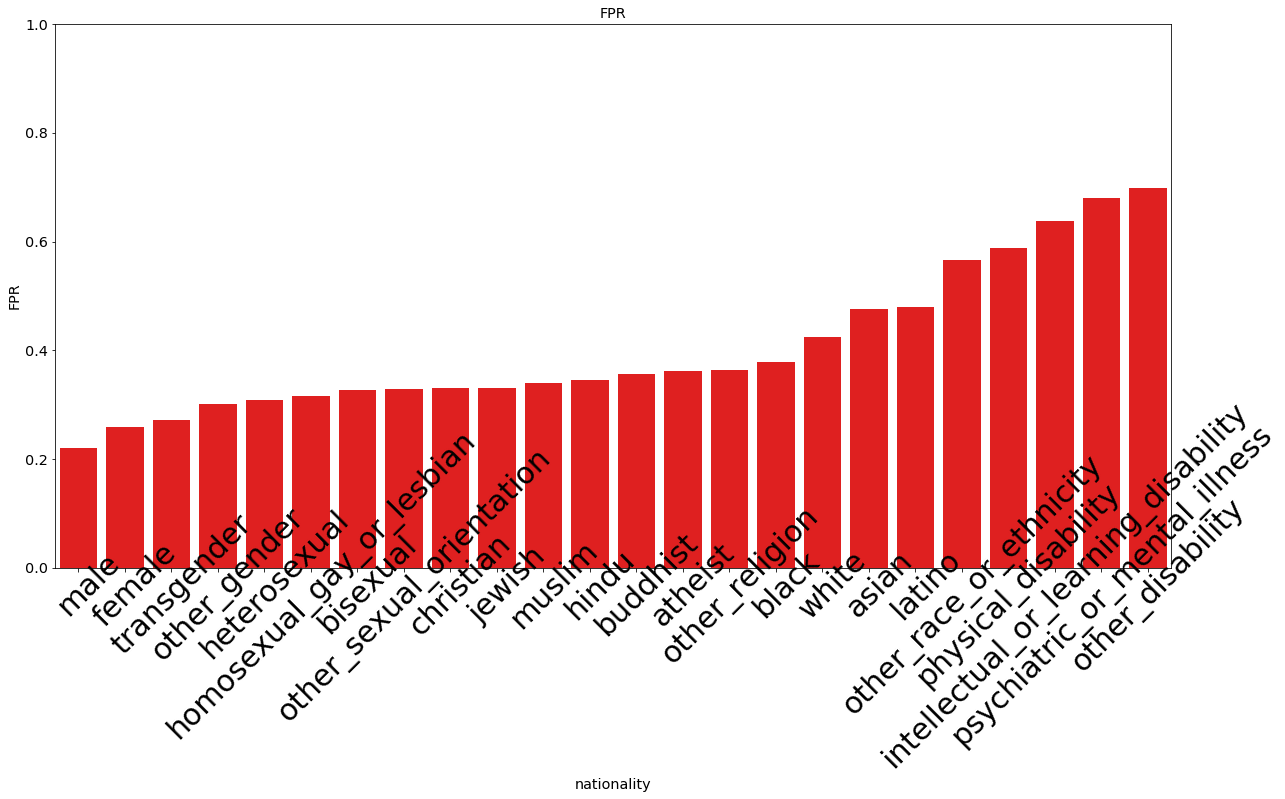

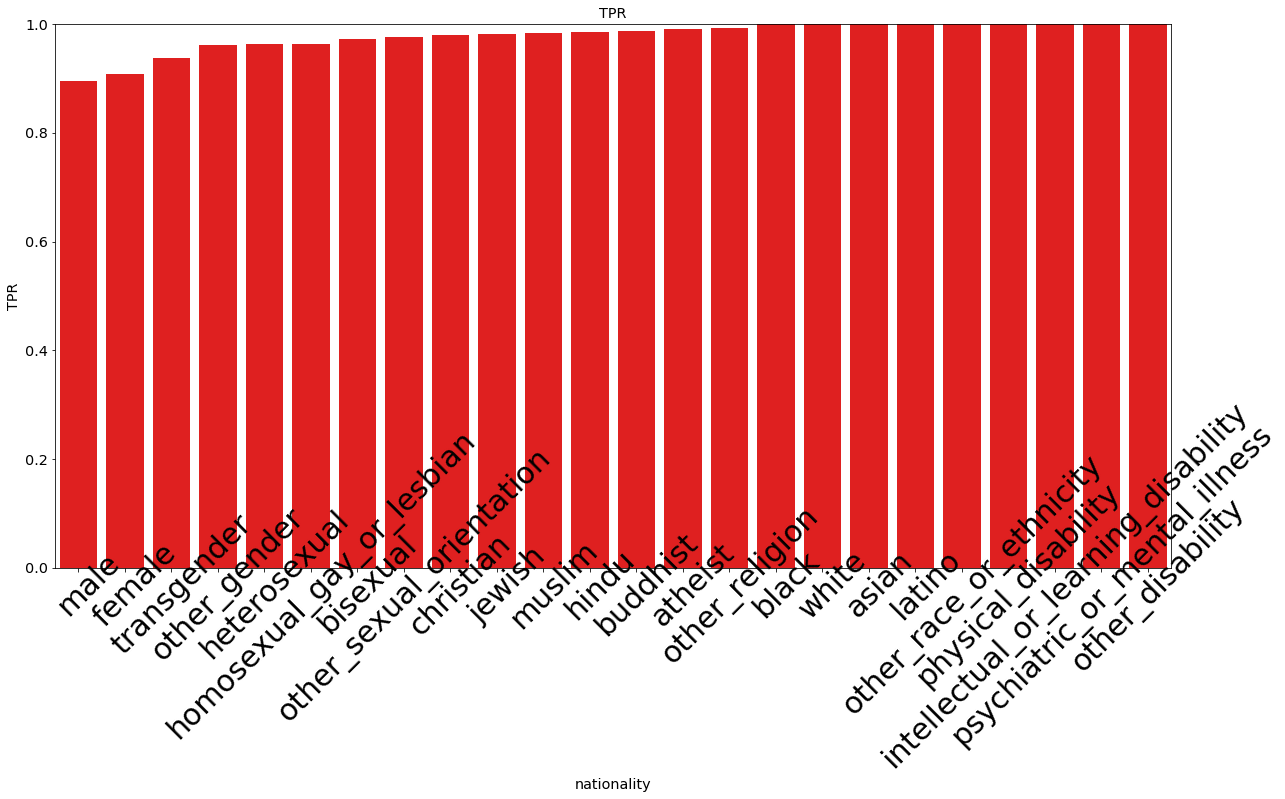

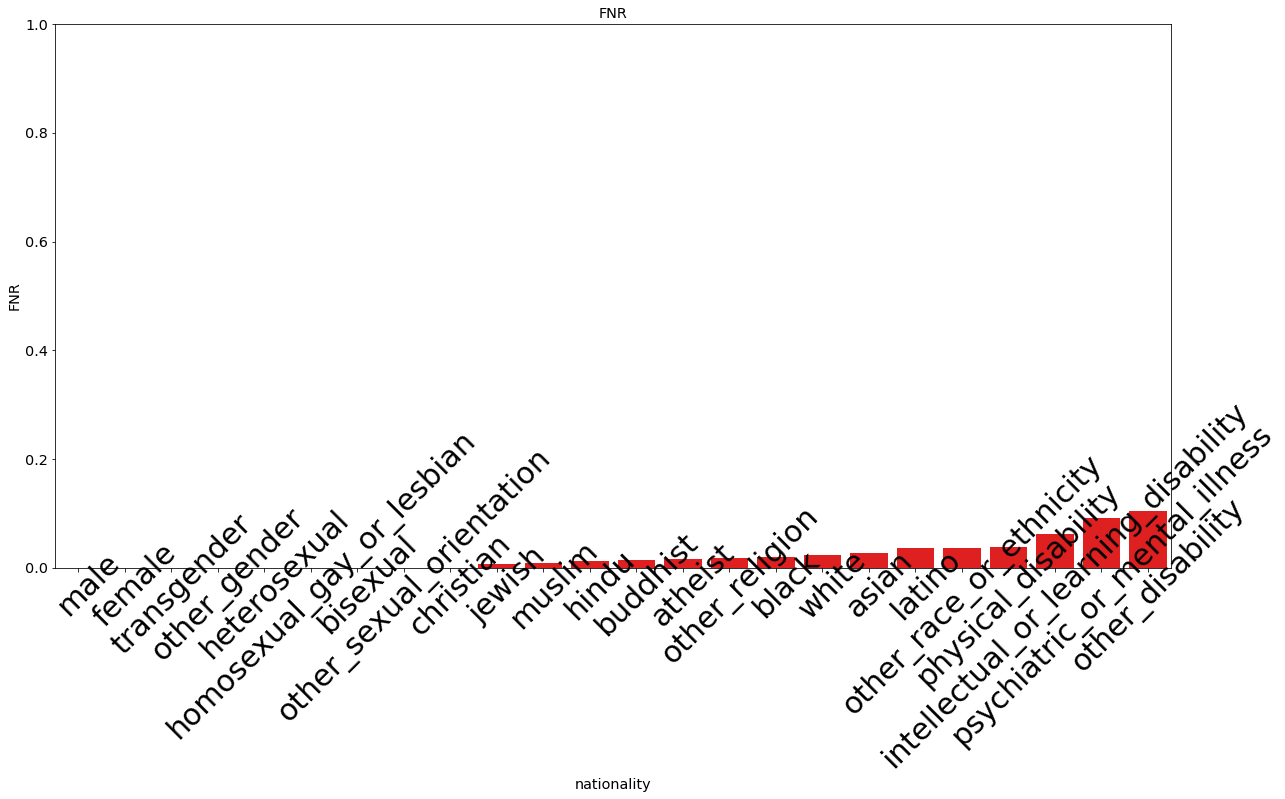

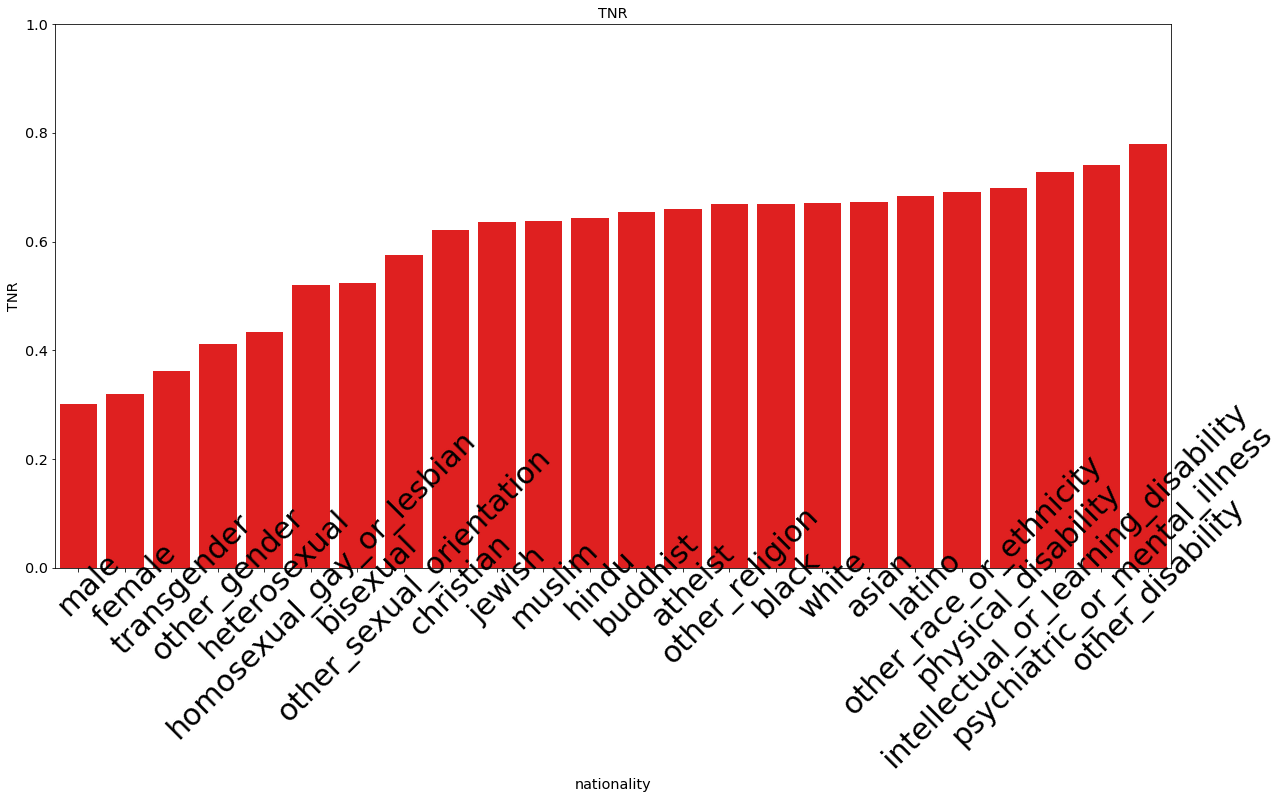

In [49]:
#The classifier is really good at not tagging non-toxic comments as toxic
#It tags a significant nmber of non-toxic comments as toxic
sdf["nationality"] =sdf.index
for i in ["FPR","TPR","FNR","TNR"]:
    ax = sns.barplot(x="nationality",y=i,data=sdf.sort_values(i),color="red",orient="v")
    _ = ax.set_xticklabels(sdf.nationality, rotation=45, rotation_mode="anchor")
    ax.set_title(i)
    ax.set_ylim((0,1))
    plt.show()

In [50]:
sdf

,mentions,mentioned_toxic_comments,mentioned_non_toxic_comments,not_mentioned,TN,FP,FN,TP,TPR,FPR,FP_over_P,TNR,FNR,nationality
male,3511,523,2988,18066,1999,989,12,511,0.977055,0.330991,0.659333,0.669009,0.022945,male
female,3454,485,2969,18123,2072,897,13,472,0.973196,0.302122,0.655223,0.697878,0.026804,female
transgender,233,38,195,21344,102,93,0,38,1.000000,0.476923,0.709924,0.523077,0.000000,transgender
other_gender,61,9,52,21516,35,17,0,9,1.000000,0.326923,0.653846,0.673077,0.000000,other_gender
heterosexual,118,19,99,21459,43,56,2,17,0.894737,0.565657,0.767123,0.434343,0.105263,heterosexual
homosexual_gay_or_lesbian,679,179,500,20898,181,319,3,176,0.983240,0.638000,0.644444,0.362000,0.016760,homosexual_gay_or_lesbian
bisexual,123,16,107,21454,70,37,1,15,0.937500,0.345794,0.711538,0.654206,0.062500,bisexual
other_sexual_orientation,95,15,80,21482,46,34,0,15,1.000000,0.425000,0.693878,0.575000,0.000000,other_sexual_orientation
christian,3136,293,2843,18441,2109,734,11,282,0.962457,0.258178,0.722441,0.741822,0.037543,christian
jewish,504,79,425,21073,221,204,1,78,0.987342,0.480000,0.723404,0.520000,0.012658,jewish


# Let's look at some words

In [53]:
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer,clf)
clf_pred = c.predict(tdfn.comment_text)
tdfn["clf_pred"] = clf_pred

/Users/benwolfson/anaconda3/envs/data_resp/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


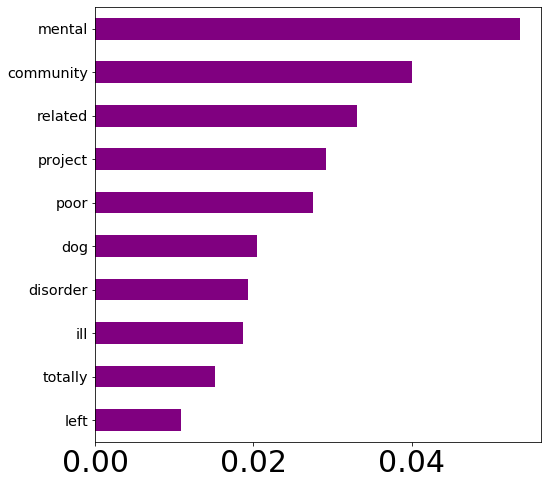

In [54]:
def get_incorrectly_tagged_indices(df,subgroup,mention_threshold,incorrect_tag):
    df_sub = df[df[subgroup] > mention_threshold]
    df_sub = df_sub[df_sub["bin_toxicity"] == incorrect_tag]
    df_sub_clf = df_sub[df_sub["predicted_toxicity"] == df_sub["clf_pred"]]
    return df_sub_clf[df_sub_clf["bin_toxicity"] != df_sub_clf["predicted_toxicity"]].index.values



def interpret_data(func,test_set,target, class_names,indices=range(5),num_indices = 30,plot=False,file_prefix="part_b_i"):
    explainer = LimeTextExplainer(class_names=class_names)
    word_lists = []
    if len(indices) > num_indices:
        indices = indices[:num_indices]
    for r_idx in indices:
        exp = explainer.explain_instance(test_set[r_idx], func, num_features=10)
        if plot:
            %matplotlib inline
            #fig = exp.as_pyplot_figure()
            if target[r_idx] == 1:
                tclass = "Toxic"
            else:
                tclass = "Non-Toxic"
            print(F"the correct classification is {tclass}")
            exp.show_in_notebook()
            #exp.save_to_file(f"{file_prefix}_{r_idx}.html")
        word_lists.append(dict(exp.as_list()))
        
    d = {}
    for wd in word_lists:
        for k,v in wd.items():
            if len(k) < 2:
                continue
            if k not in d:
                d[k] = abs(wd[k])
            else:
                d[k] += abs(wd[k])
        
    return d


def get_incorrect_examples(tdfn,identity,mention_threshold,toxicity):
    get_incorrect_examples.c = make_pipeline(vectorizer, clf)
    indices =get_incorrectly_tagged_indices(tdfn,identity,mention_threshold,toxicity)
    return interpret_data(get_incorrect_examples.c.predict_proba, tdfn.comment_text,tdfn["bin_toxicity"],['non_toxic','toxic'],indices = indices[0:5])


words = get_incorrect_examples(tdfn,'white',mention_threshold,1)
exp_df = pd.Series(words)
fig, ax = plt.subplots(figsize=(8, 8))
exp_df = exp_df.sort_values()
exp_df.iloc[0:10].plot.barh(x='index',
                      y='Sum_Weights',
                     color="purple",ax=ax)

In [ ]:
#tdfn.to_csv("known_identity_df.csv",index = True)
#sdf.to_csv("summary_df.csv",index = True)

In [ ]:
#pd.read_csv("summary_df.csv",index_col=0)

# ADS

In [56]:
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
from IPython.display import display
import ipywidgets as widgets
from IPython.core.display import HTML
from time import sleep
import pandas as pd

tdfn =pd.read_csv("known_identity_df.csv",index_col=0)
sdf = pd.read_csv("summary_df.csv",index_col=0)

#using tdfn and sdf from above
classes_of_interest = ['white','black','female','homosexual_gay_or_lesbian','christian','hindu']
options={"All toxic comments being flagged":0,\
         "Non-toxic comments not being flagged as toxic":1,\
         "Percentage of comments that are flagged as toxic are not toxic":2}
inv_options = {v:k for k,v in options.items()}



def display_df_widget(display_df,col):
    display(display_df.sort_values(col,ascending=False))

def sorted_df_widget(display_df,cols):
    return interactive(display_df_widget,display_df = fixed(display_df.loc[classes_of_interest]),col=display_df.columns)


def get_sample_text(base_df,nationality,toxicity):
    toxicity = (toxicity == "Toxic")*1
    sub_df = base_df[(base_df[nationality] > .5) & (base_df["toxicity"] == toxicity)]
    print(sub_df.sample(1)["comment_text"].values[0])

    
def get_explained_text(base_df,nationality,mention_threshold,toxicity,c):
    toxicity = (toxicity == "Toxic")*1
    indices = get_incorrectly_tagged_indices(base_df,nationality,mention_threshold,toxicity)
    #indices = get_incorrect_examples(tdfn,'christian',mention_threshold,0)

    exp = interpret_data(c.predict_proba, base_df.comment_text,base_df["bin_toxicity"],['non_toxic','toxic'],indices,1,True)


def get_recipe_widget(base_df):
    recipe_df = base_df.iloc[:,0:4]
    recipe_df.columns = ["Mentions","Toxic Comments","Non-Toxic Comments","Not Mentioned"]
    return sorted_df_widget(recipe_df,recipe_df.columns)

def get_ingredient_widget(base_df):
    idf = base_df.iloc[:,8:11]
    idf.columns = ["What percentage of the toxic comments are classified as toxic? Low values means many toxic comments were not flagged",\
                   "What percent of comments that are not toxic are flagged as toxic? High values mean many non-toxic comments are flagged as toxic",\
                  "What percentage of comments that are flagged as toxic are not? High values indicate rate of incorrect toxic labeling"]
#     idf.columns =["(# Comments Predicted Toxic)/(# Toxic Comments)",\
#                  "(# Comments Incorrectly Predicted Toxic)/(# Comments Predicted Toxic)"]
    idf = idf.apply(lambda x: round(x,2))
    return sorted_df_widget(idf,idf.columns)

def select_importance_widget():
    pass



def get_sample_text_widget(base_df):
    return interactive(get_sample_text,base_df=fixed(base_df),\
                       nationality = classes_of_interest,\
                       toxicity=["Toxic","Non-Toxic"])


def get_explained_text_widget(base_df):
    return interactive(get_explained_text,base_df = fixed(base_df),\
                                          nationality=classes_of_interest,\
                                          mention_threshold=fixed(.1),
                                          toxicity=["Toxic","Non-Toxic"],\
                                          c=fixed(c))
                              

def get_fpr_risk_widget(base_df):
    idf = base_df.iloc[:,8:11]
    high_f_rate = idf.iloc[:,-1]
        


        
        
def get_question_widget():
    slider = widgets.SelectMultiple(options = options)
    return slider


def get_registered_output(widget,func,*func_args,**kw_func_args):
    output = widgets.Output()
    def update_output(change_dict):
        output.clear_output()
        with output:
            func(change_dict,*func_args,**kw_func_args)
    
    widget.observe(update_output)
    return output



def goal_func(change_dict,base_df):
    option = change_dict['old']['index'][0]
    idf = base_df.iloc[:,8:11].loc[classes_of_interest]
    idf = idf.sort_values(by=[idf.columns[option]],ascending = False)
    idf = idf.iloc[:,[option]]*100
    idf.columns = [inv_options[option]]
    display(HTML(f"<h3>You chose <span style='color:blue'>'{inv_options[option]}'</span> as your goal: </h3>"))
    display(HTML("<p>Accordingly, your groups of interest rank as follows:</p>"))
    if option == 0:
        s = (idf\
         .style\
         .format({idf.columns[0]:'{0:,.0f}%'})\
         .bar(color=['#d65f5f', '#5fba7d'],vmin=0,vmax=100,subset = [idf.columns[0]])\
         .set_caption('Results'))
    else:
        s = (idf\
         .style\
         .format({idf.columns[0]:'{0:,.0f}%'})\
             .bar(subset = [idf.columns[0]], color=['#5fba7d','#d65f5f'],vmin=0,vmax=100)\
         .set_caption('Results'))
    display(s)
        
    
    
    


    

importance_widget = get_question_widget()
goal_output = get_registered_output(importance_widget,goal_func,sdf)
recipe_widget = get_recipe_widget(sdf)
ingredient_widget = get_ingredient_widget(sdf)
text_widget = get_sample_text_widget(tdfn)
exp_text_widget = get_explained_text_widget(tdfn)
display(HTML("<h1>Goal</h1>"))
display(HTML("<h3>I care most about ...</h3>"))
display(importance_widget)
display(HTML("<h1>Recipe</h1>"))
display(recipe_widget)
display(HTML("<h1>Sample Comment</h1>"))
display(text_widget)
display(HTML("<h1>Ingredients</h1>"))
display(ingredient_widget)
display(HTML("<h1>Tagged Comment</h1>"))
display(exp_text_widget)
display(HTML("<h1>Evaluation</h1>"))
display(goal_output)

    

SelectMultiple(options={'All toxic comments being flagged': 0, 'Non-toxic comments not being flagged as toxic'…

interactive(children=(Dropdown(description='col', options=('Mentions', 'Toxic Comments', 'Non-Toxic Comments',…

interactive(children=(Dropdown(description='nationality', options=('white', 'black', 'female', 'homosexual_gay…

interactive(children=(Dropdown(description='col', options=('What percentage of the toxic comments are classifi…

interactive(children=(Dropdown(description='nationality', options=('white', 'black', 'female', 'homosexual_gay…

Output()